<center><h1> Image Generation using Variation Autoencoder </h1></center>

## Importing Necessary Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd
import keras 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import cv2
from tqdm import tqdm

# images_path1 = '/kaggle/input/animefacedataset/images/'
images_path =  './images/'

In [47]:
image_file_names = list(os.listdir(images_path))
print(len(image_file_names))

heights = []
widths = []
file_paths = []
for name in tqdm(image_file_names):
    path = images_path + name
    height, width, _ = cv2.imread(path).shape
    heights.append(height)
    widths.append(width)
    file_paths.append(path)


63565


100%|██████████████████████████████████████████████████████████████████████████| 63565/63565 [00:36<00:00, 1725.22it/s]


In [48]:
df_temp = pd.DataFrame()
df_temp["file_paths"] = file_paths
df_temp["height"] = heights
df_temp["width"] = widths
df_temp

,file_paths,height,width
0,./images/0_2000.jpg,63,63
1,./images/10000_2004.jpg,62,62
2,./images/10001_2004.jpg,79,79
3,./images/10002_2004.jpg,51,51
4,./images/10003_2004.jpg,77,77
...,...,...,...
63560,./images/9998_2004.jpg,41,41
63561,./images/9999_2004.jpg,66,66
63562,./images/999_2000.jpg,72,72
63563,./images/99_2000.jpg,65,65


## Visualizing the Data for Better Understanding

In [51]:
def getCountDF(df , attribute = ""):
    
    vals = list(dict(df[attribute].value_counts()).keys())
    counts = list(dict(df[attribute].value_counts()).values())
    df1 = pd.DataFrame()
    df1[attribute] = vals
    df1["count"] = counts
    return df1

def visualize(df):
    sns.set_style('darkgrid')
    fig,ax = plt.subplots(2,1 , figsize=(20,15))
    df1 = getCountDF(df , "height")
    df2 = getCountDF(df , "width")
    
    df1.plot.scatter(x='height' , y= 'count' , ax= ax[0])
    df2.plot.scatter(x='width' , y= 'count' , ax= ax[1])
    plt.show()
    return 
    

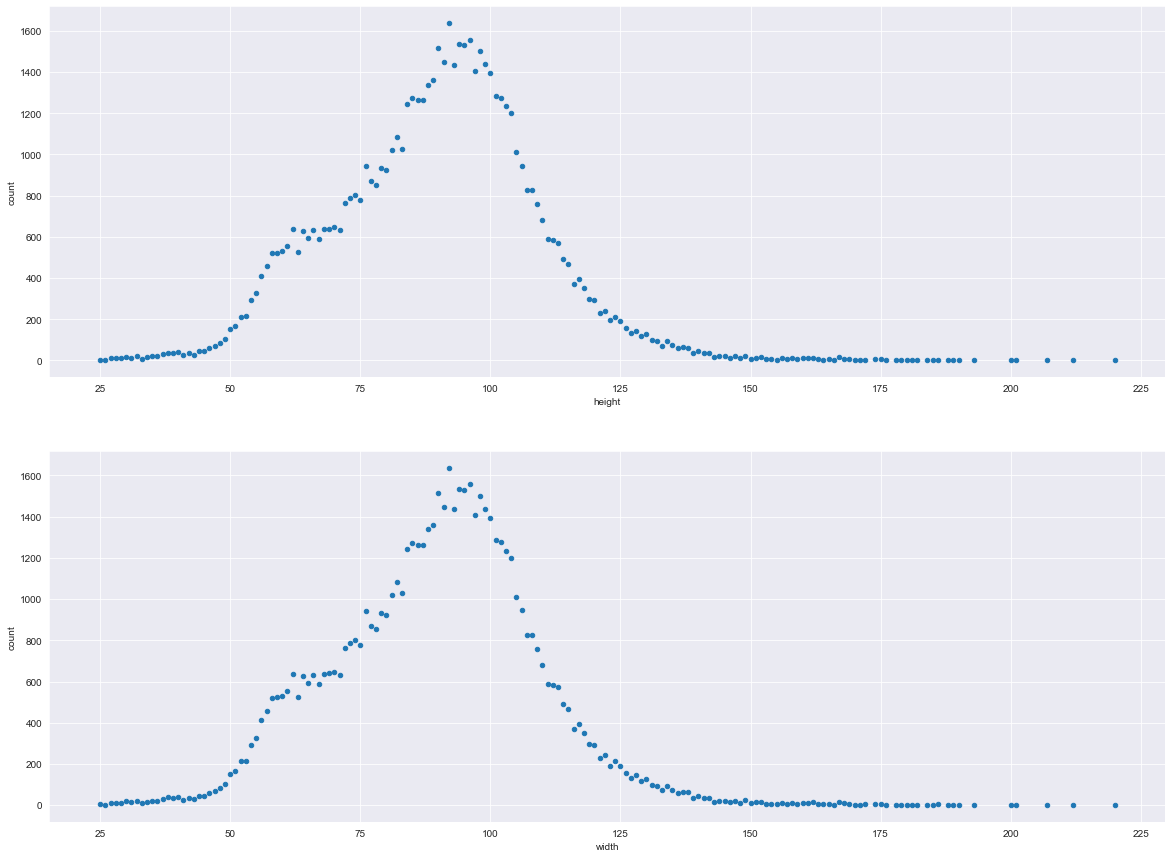

In [52]:
visualize(df_temp)

100x100 is chosen to avoid blurry images to some extent according to the above distribution as resampling the image to higher dimensions will result in checkboard effect and blurry images

In [57]:
df_final = df_temp[(df_temp['height'] >= 100) & (df_temp['width'] >= 100)]
df_final.to_csv("final_100x100.csv")

In [59]:
df_final.reset_index(drop = True)

,file_paths,height,width
0,./images/1003_2000.jpg,116,116
1,./images/10043_2004.jpg,140,140
2,./images/1004_2000.jpg,127,127
3,./images/10057_2004.jpg,130,130
4,./images/10120_2004.jpg,108,108
...,...,...,...
18708,./images/9931_2004.jpg,150,150
18709,./images/9966_2004.jpg,116,116
18710,./images/997_2000.jpg,188,188
18711,./images/9981_2004.jpg,110,110


## Preprocesing Data and Creating a Datagenerator

In [60]:
shape = (100,100,3)
def preprocess(path , height = shape[0] , width = shape[1]):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (height,width))
    image = image / 255.0
    image = tf.reshape(image, shape = (height, width, 3,))
    return image

img_paths = df_final["file_paths"]

batch_size = 50
training_dataset = tf.data.Dataset.from_tensor_slices((img_paths))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(2601).batch(batch_size)

In [79]:
len(training_dataset)

375

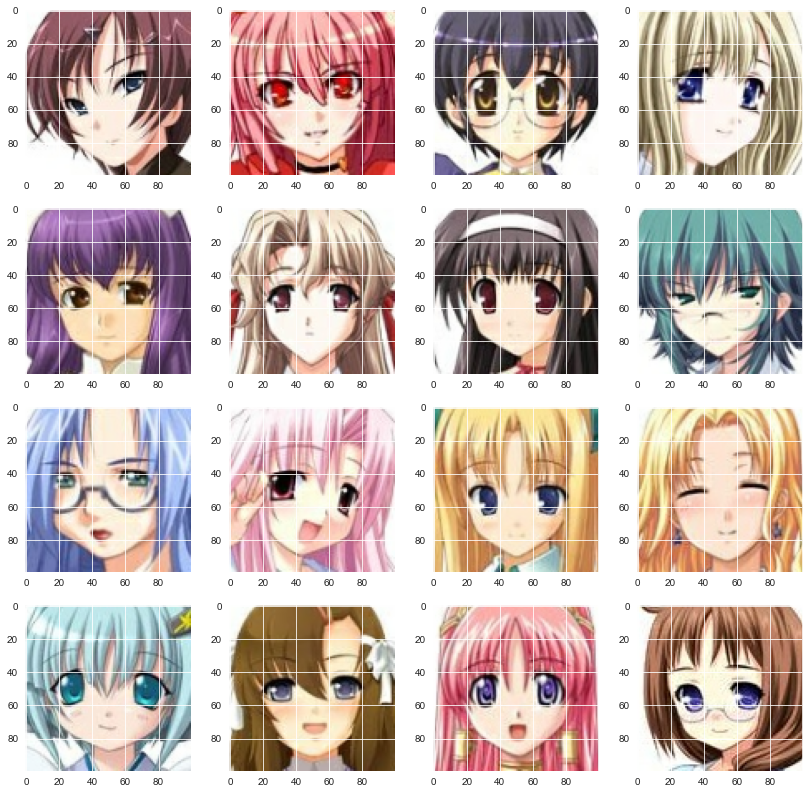

In [62]:
# Visualizing the Data

fig, axes = plt.subplots(4,4, figsize = (14,14))
sample = training_dataset.unbatch().take(16)
sample = [image for image in sample]

idx = 0
for row in range(4):
    for column in range(4):
        axes[row, column].imshow(sample[idx])
        idx+=1

## Building and Training VAE

In [74]:
latent_dim = 300

from keras.models import Sequential, Model
from keras.initializers import HeUniform
from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, GlobalAveragePooling2D, BatchNormalization, Lambda, Reshape, Activation, MaxPool2D
from keras.layers.activation import LeakyReLU
from keras.activations import selu
from keras.layers import Multiply, Add
from keras.optimizers import Adam

from keras import backend as K
K.clear_session()

In [75]:
initializer = HeUniform(seed = 26)
encoder_input = Input(shape = shape)

x = Conv2D(25, kernel_size=5, activation = LeakyReLU(0.02), strides = 1, padding = 'same' , kernel_initializer = initializer)(encoder_input)
x = BatchNormalization()(x)

x = Conv2D(50, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same' , kernel_initializer = initializer)(x)
x = BatchNormalization()(x)

x = Conv2D(100, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same' , kernel_initializer = initializer)(x)
x = BatchNormalization()(x)

x = Conv2D(200, kernel_size=5, activation = LeakyReLU(0.02), strides = 5, padding = 'same' , kernel_initializer = initializer)(x)
x = BatchNormalization()(x)

x = Conv2D(400, kernel_size=5, activation = LeakyReLU(0.02), strides = 5, padding = 'same' , kernel_initializer = initializer)(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(400, activation = 'selu' , kernel_initializer='lecun_normal')(x)
encoder_output = BatchNormalization()(x)

# sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 25  1900        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 100, 25  100        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [76]:
# build the decoder

decoder = Sequential()
decoder.add(Dense(1*1*400, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

# decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((1,1,400)))

decoder.add(Conv2DTranspose(200, (5,5), activation = LeakyReLU(0.02), strides = 5, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(100, (5,5), activation = LeakyReLU(0.02), strides = 5, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(50, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(25, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(3, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 400)               120400    
                                                                 
 batch_normalization_6 (Batc  (None, 400)              1600      
 hNormalization)                                                 
                                                                 
 reshape (Reshape)           (None, 1, 1, 400)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 5, 5, 200)        2000200   
 nspose)                                                         
                                                                 
 batch_normalization_7 (Batc  (None, 5, 5, 200)        800       
 hNormalization)                                                 
                                                        

In [77]:
def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)



# conbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           [(None, 300),        3064600     ['input_1[0][0]']                
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                                  
 sequential (Sequential)        (None, 100, 100, 3)  2782015     ['encoder[0][2]']              

In [78]:
# A function to save image result of training on images

def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    model.save("./Models/VAE-AnimeFace")
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "./Training Images/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

In [80]:
# train vae

from keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 100

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())
            
            kl = sum(model.losses)
            kl_losses.append(kl.numpy())
            
            train_loss = 0.01 * kl + mse_loss
            
            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            if (step+1) % 100 == 0:
                save_images(decoder, epoch, step, random_vector)
    print("Epoch: %s - MSE loss: %s - KL loss: %s" % (epoch, mse_loss.numpy(), kl.numpy()))


1/1 [==============================] - 4s 4s/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch:  1
1/1 [==============================] - 0s 99ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 31ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 98ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 1 - MSE loss: 0.03189517 - KL loss: 0.21923028
Epoch:  2
1/1 [==============================] - 0s 33ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 83ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 90ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 2 - MSE loss: 0.02768963 - KL loss: 0.274175
Epoch:  3
1/1 [==============================] - 0s 95ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 90ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 101ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 3 - MSE loss: 0.02940902 - KL loss: 0.2907315
Epoch:  4
1/1 [==============================] - 0s 83ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 105ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 87ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 4 - MSE loss: 0.025058359 - KL loss: 0.337151
Epoch:  5
1/1 [==============================] - 0s 88ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 102ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 92ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 5 - MSE loss: 0.025411075 - KL loss: 0.32825306
Epoch:  6
1/1 [==============================] - 0s 96ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 105ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 69ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 6 - MSE loss: 0.024365058 - KL loss: 0.34405065
Epoch:  7
1/1 [==============================] - 0s 106ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 84ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 39ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 7 - MSE loss: 0.0245535 - KL loss: 0.37680063
Epoch:  8
1/1 [==============================] - 0s 103ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 105ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 86ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 8 - MSE loss: 0.021579813 - KL loss: 0.33141834
Epoch:  9
1/1 [==============================] - 0s 77ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 67ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 99ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 9 - MSE loss: 0.023230046 - KL loss: 0.31525114
Epoch:  10
1/1 [==============================] - 0s 90ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 98ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 89ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 10 - MSE loss: 0.023160286 - KL loss: 0.32095584
Epoch:  11
1/1 [==============================] - 0s 81ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 34ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 83ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 11 - MSE loss: 0.021241115 - KL loss: 0.37990984
Epoch:  12
1/1 [==============================] - 0s 87ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 49ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 48ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 12 - MSE loss: 0.020509273 - KL loss: 0.33732095
Epoch:  13
1/1 [==============================] - 0s 87ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 104ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 77ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 13 - MSE loss: 0.017801916 - KL loss: 0.3412236
Epoch:  14
1/1 [==============================] - 0s 89ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 103ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 86ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 14 - MSE loss: 0.016251244 - KL loss: 0.28693464
Epoch:  15
1/1 [==============================] - 0s 100ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 45ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 101ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 15 - MSE loss: 0.023018284 - KL loss: 0.3897679
Epoch:  16
1/1 [==============================] - 0s 84ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 100ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 99ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 16 - MSE loss: 0.023032354 - KL loss: 0.34265187
Epoch:  17
1/1 [==============================] - 0s 84ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 75ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 93ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 17 - MSE loss: 0.019644624 - KL loss: 0.32706055
Epoch:  18
1/1 [==============================] - 0s 96ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 101ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 69ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 18 - MSE loss: 0.019590545 - KL loss: 0.29352838
Epoch:  19
1/1 [==============================] - 0s 86ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 85ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 100ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 19 - MSE loss: 0.018787624 - KL loss: 0.309399
Epoch:  20
1/1 [==============================] - 0s 56ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 92ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 65ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 20 - MSE loss: 0.018036857 - KL loss: 0.31945503
Epoch:  21
1/1 [==============================] - 0s 66ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 89ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 89ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 21 - MSE loss: 0.018237935 - KL loss: 0.29887083
Epoch:  22
1/1 [==============================] - 0s 100ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 100ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 89ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 22 - MSE loss: 0.017275529 - KL loss: 0.2957999
Epoch:  23
1/1 [==============================] - 0s 41ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 44ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 50ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 23 - MSE loss: 0.016450118 - KL loss: 0.28869078
Epoch:  24
1/1 [==============================] - 0s 40ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 88ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 88ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 24 - MSE loss: 0.019041182 - KL loss: 0.35098693
Epoch:  25
1/1 [==============================] - 0s 80ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 48ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 86ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 25 - MSE loss: 0.018560484 - KL loss: 0.37376314
Epoch:  26
1/1 [==============================] - 0s 78ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 84ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 97ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 26 - MSE loss: 0.015741304 - KL loss: 0.3294326
Epoch:  27
1/1 [==============================] - 0s 109ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 90ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 100ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 27 - MSE loss: 0.019462911 - KL loss: 0.3360193
Epoch:  28
1/1 [==============================] - 0s 91ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 105ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 81ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 28 - MSE loss: 0.017207557 - KL loss: 0.3327687
Epoch:  29
1/1 [==============================] - 0s 93ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 70ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 100ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 29 - MSE loss: 0.017339889 - KL loss: 0.3083644
Epoch:  30
1/1 [==============================] - 0s 85ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 96ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 72ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 30 - MSE loss: 0.015907928 - KL loss: 0.34694844
Epoch:  31
1/1 [==============================] - 0s 93ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 105ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 97ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 31 - MSE loss: 0.016091142 - KL loss: 0.3438069
Epoch:  32
1/1 [==============================] - 0s 119ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 87ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 92ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 32 - MSE loss: 0.016419102 - KL loss: 0.32666826
Epoch:  33
1/1 [==============================] - 0s 70ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 87ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 87ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 33 - MSE loss: 0.01681073 - KL loss: 0.34304047
Epoch:  34
1/1 [==============================] - 0s 98ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 91ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 92ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 34 - MSE loss: 0.016236894 - KL loss: 0.35158277
Epoch:  35
1/1 [==============================] - 0s 101ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 77ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 93ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 35 - MSE loss: 0.020583011 - KL loss: 0.345456
Epoch:  36
1/1 [==============================] - 0s 78ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 96ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 103ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 36 - MSE loss: 0.015048188 - KL loss: 0.31421015
Epoch:  37
1/1 [==============================] - 0s 77ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 98ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 86ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 37 - MSE loss: 0.016406115 - KL loss: 0.31712052
Epoch:  38
1/1 [==============================] - 0s 95ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 93ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 74ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 38 - MSE loss: 0.018477093 - KL loss: 0.35910395
Epoch:  39
1/1 [==============================] - 0s 91ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 95ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 99ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 39 - MSE loss: 0.017260239 - KL loss: 0.34529027
Epoch:  40
1/1 [==============================] - 0s 80ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 45ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 100ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 40 - MSE loss: 0.019640643 - KL loss: 0.33855638
Epoch:  41
1/1 [==============================] - 0s 100ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 101ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 95ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 41 - MSE loss: 0.016733434 - KL loss: 0.34065047
Epoch:  42
1/1 [==============================] - 0s 99ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 39ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 89ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 42 - MSE loss: 0.018808737 - KL loss: 0.36457974
Epoch:  43
1/1 [==============================] - 0s 71ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 66ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 78ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 43 - MSE loss: 0.017087733 - KL loss: 0.34495562
Epoch:  44
1/1 [==============================] - 0s 70ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 93ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 105ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 44 - MSE loss: 0.016552698 - KL loss: 0.36091912
Epoch:  45
1/1 [==============================] - 0s 95ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 99ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 77ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 45 - MSE loss: 0.01659882 - KL loss: 0.34201717
Epoch:  46
1/1 [==============================] - 0s 99ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 102ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 65ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 46 - MSE loss: 0.01646913 - KL loss: 0.3671128
Epoch:  47
1/1 [==============================] - 0s 93ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 88ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 99ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 47 - MSE loss: 0.016132863 - KL loss: 0.3335109
Epoch:  48
1/1 [==============================] - 0s 98ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 65ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 82ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 48 - MSE loss: 0.013189018 - KL loss: 0.3362899
Epoch:  49
1/1 [==============================] - 0s 102ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 42ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 67ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 49 - MSE loss: 0.017767945 - KL loss: 0.36448845
Epoch:  50
1/1 [==============================] - 0s 37ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 103ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 47ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 50 - MSE loss: 0.015268009 - KL loss: 0.38339242
Epoch:  51
1/1 [==============================] - 0s 102ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 88ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 97ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 51 - MSE loss: 0.017400213 - KL loss: 0.36440197
Epoch:  52
1/1 [==============================] - 0s 56ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 76ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 96ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 52 - MSE loss: 0.015587938 - KL loss: 0.34890682
Epoch:  53
1/1 [==============================] - 0s 106ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 93ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 109ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 53 - MSE loss: 0.014119376 - KL loss: 0.34259036
Epoch:  54
1/1 [==============================] - 0s 102ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 58ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 95ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 54 - MSE loss: 0.016128015 - KL loss: 0.33498847
Epoch:  55
1/1 [==============================] - 0s 102ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 82ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 51ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 55 - MSE loss: 0.015636776 - KL loss: 0.34713042
Epoch:  56
1/1 [==============================] - 0s 75ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 81ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 65ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 56 - MSE loss: 0.014681701 - KL loss: 0.35440245
Epoch:  57
1/1 [==============================] - 0s 87ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 98ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 93ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 57 - MSE loss: 0.017354235 - KL loss: 0.4052243
Epoch:  58
1/1 [==============================] - 0s 89ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 91ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 100ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 58 - MSE loss: 0.015298298 - KL loss: 0.37701267
Epoch:  59
1/1 [==============================] - 0s 97ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 85ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 74ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 59 - MSE loss: 0.015906692 - KL loss: 0.3442521
Epoch:  60
1/1 [==============================] - 0s 84ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 86ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 60ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 60 - MSE loss: 0.015414328 - KL loss: 0.3371206
Epoch:  61
1/1 [==============================] - 0s 74ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 97ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 81ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 61 - MSE loss: 0.014595586 - KL loss: 0.33751494
Epoch:  62
1/1 [==============================] - 0s 83ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 82ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 84ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 62 - MSE loss: 0.014202669 - KL loss: 0.35659975
Epoch:  63
1/1 [==============================] - 0s 89ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 103ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 101ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 63 - MSE loss: 0.014983058 - KL loss: 0.3521547
Epoch:  64
1/1 [==============================] - 0s 105ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 96ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 102ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 64 - MSE loss: 0.014163835 - KL loss: 0.36648747
Epoch:  65
1/1 [==============================] - 0s 110ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 92ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 89ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 65 - MSE loss: 0.015951687 - KL loss: 0.3848775
Epoch:  66
1/1 [==============================] - 0s 78ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 69ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 84ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 66 - MSE loss: 0.014327049 - KL loss: 0.35360128
Epoch:  67
1/1 [==============================] - 0s 87ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 81ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 49ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 67 - MSE loss: 0.016134229 - KL loss: 0.3639242
Epoch:  68
1/1 [==============================] - 0s 89ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 66ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 52ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 68 - MSE loss: 0.017067738 - KL loss: 0.34572932
Epoch:  69
1/1 [==============================] - 0s 69ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 44ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 65ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 69 - MSE loss: 0.013492921 - KL loss: 0.36544773
Epoch:  70
1/1 [==============================] - 0s 63ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 70ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 71ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 70 - MSE loss: 0.014198649 - KL loss: 0.33644137
Epoch:  71
1/1 [==============================] - 0s 94ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 66ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 76ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 71 - MSE loss: 0.013217652 - KL loss: 0.35885754
Epoch:  72
1/1 [==============================] - 0s 52ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 85ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 44ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 72 - MSE loss: 0.015356578 - KL loss: 0.33388075
Epoch:  73
1/1 [==============================] - 0s 54ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 91ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 78ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 73 - MSE loss: 0.016030205 - KL loss: 0.38891786
Epoch:  74
1/1 [==============================] - 0s 82ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 101ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 101ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 74 - MSE loss: 0.01258381 - KL loss: 0.34302872
Epoch:  75
1/1 [==============================] - 0s 101ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 26ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 92ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 75 - MSE loss: 0.013547139 - KL loss: 0.3445219
Epoch:  76
1/1 [==============================] - 0s 98ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 86ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 86ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 76 - MSE loss: 0.015355538 - KL loss: 0.38486674
Epoch:  77
1/1 [==============================] - 0s 96ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 71ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 26ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 77 - MSE loss: 0.014579651 - KL loss: 0.39124206
Epoch:  78
1/1 [==============================] - 0s 90ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 62ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 104ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 78 - MSE loss: 0.013160918 - KL loss: 0.33526203
Epoch:  79
1/1 [==============================] - 0s 103ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 93ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 96ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 79 - MSE loss: 0.014962346 - KL loss: 0.35434425
Epoch:  80
1/1 [==============================] - 0s 97ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 90ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 62ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 80 - MSE loss: 0.016590271 - KL loss: 0.38836923
Epoch:  81
1/1 [==============================] - 0s 106ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 90ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 59ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 81 - MSE loss: 0.013631593 - KL loss: 0.3587167
Epoch:  82
1/1 [==============================] - 0s 86ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 104ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 25ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 82 - MSE loss: 0.016062126 - KL loss: 0.3671848
Epoch:  83
1/1 [==============================] - 0s 101ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 104ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 104ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 83 - MSE loss: 0.016076311 - KL loss: 0.38581875
Epoch:  84
1/1 [==============================] - 0s 104ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 92ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 94ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 84 - MSE loss: 0.014586051 - KL loss: 0.37363815
Epoch:  85
1/1 [==============================] - 0s 28ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 35ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 90ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 85 - MSE loss: 0.01404931 - KL loss: 0.3497464
Epoch:  86
1/1 [==============================] - 0s 86ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 105ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 25ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 86 - MSE loss: 0.015465312 - KL loss: 0.34838146
Epoch:  87
1/1 [==============================] - 0s 101ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 98ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 65ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 87 - MSE loss: 0.0144477235 - KL loss: 0.33330375
Epoch:  88
1/1 [==============================] - 0s 98ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 100ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 99ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 88 - MSE loss: 0.01628683 - KL loss: 0.41820413
Epoch:  89
1/1 [==============================] - 0s 65ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 103ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 62ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 89 - MSE loss: 0.014309024 - KL loss: 0.38107765
Epoch:  90
1/1 [==============================] - 0s 75ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 94ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 89ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 90 - MSE loss: 0.012564682 - KL loss: 0.38015696
Epoch:  91
1/1 [==============================] - 0s 58ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 92ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 91ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 91 - MSE loss: 0.011338381 - KL loss: 0.36059803
Epoch:  92
1/1 [==============================] - 0s 30ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 98ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 30ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 92 - MSE loss: 0.012583354 - KL loss: 0.35835412
Epoch:  93
1/1 [==============================] - 0s 96ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 33ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 105ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 93 - MSE loss: 0.013625344 - KL loss: 0.33933243
Epoch:  94
1/1 [==============================] - 0s 98ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 42ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 30ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 94 - MSE loss: 0.013102491 - KL loss: 0.37016073
Epoch:  95
1/1 [==============================] - 0s 93ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 103ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 98ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 95 - MSE loss: 0.015802696 - KL loss: 0.40733677
Epoch:  96
1/1 [==============================] - 0s 91ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 103ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 99ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 96 - MSE loss: 0.014291945 - KL loss: 0.38659856
Epoch:  97
1/1 [==============================] - 0s 104ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 99ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 99ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 97 - MSE loss: 0.01246304 - KL loss: 0.34605038
Epoch:  98
1/1 [==============================] - 0s 80ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 99ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 103ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 98 - MSE loss: 0.013113831 - KL loss: 0.38966906
Epoch:  99
1/1 [==============================] - 0s 103ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 97ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 103ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 99 - MSE loss: 0.014598496 - KL loss: 0.3413538
Epoch:  100
1/1 [==============================] - 0s 104ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 102ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


1/1 [==============================] - 0s 90ms/step


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


INFO:tensorflow:Assets written to: ./Models/VAE-AnimeFace\assets


Epoch: 100 - MSE loss: 0.015389116 - KL loss: 0.39289615


## Generate Video from Saved Results

In [9]:
path = "./Training Images/"
file_names = list(os.listdir(path))
height, width = (1008 , 1008)

In [10]:
video = cv2.VideoWriter('video.avi' ,cv2.VideoWriter_fourcc(*'DIVX'), fps = 4 ,frameSize=(width,height))
for name in tqdm(file_names):
    img = cv2.imread(path+name)
    video.write(img)
        
cv2.destroyAllWindows()
video.release()

100%|████████████████████████████████████████████████████████████████████████████████| 301/301 [00:05<00:00, 51.63it/s]
